In [1]:
import os
import re

import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import numpy as np
import pandas as pd
import sklearn
from sklearn import cross_validation
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import av

In [2]:
path_to_video = '/home/saharsh/UTAustin/Sem1/EE382V Activity Sensing/VisualDiary/Code/test.mp4'
path_to_frames = '/home/saharsh/UTAustin/Sem1/EE382V Activity Sensing/VisualDiary/Code/frames/'
model_dir = '/home/saharsh/Documents/imagenet/classify_image_graph_def.pb'
images_dir = path_to_frames

In [3]:
def frame_extractor(path_to_video,path_to_frames):
    container = av.open(path_to_video)
    video = next(s for s in container.streams if s.type == b'video')
    for packet in container.demux(video):
        for frame in packet.decode():
            frame.to_image().save(path_to_frames+'/frame-%04d.jpg' % frame.index)

In [4]:
#model_dir = '/home/saharsh/Documents/imagenet/classify_image_graph_def.pb'
#images_dir = '/home/saharsh/Documents/imagenet/'

In [5]:
class ExtractFeatures:
    def __init__(self,model_path,images_dir):
        self.model = model_path
        self.list_images = [images_dir+f for f in os.listdir(images_dir) if re.search('jpg|JPG', f)]
    
    def create_graph(self):
        with gfile.FastGFile(self.model, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            _ = tf.import_graph_def(graph_def, name='')
    
    def get_layer_list(self):
        self.create_graph()
        with tf.Session() as sess:
            operation_list = sess.graph.get_operations()
            for op in operation_list:
                print op.name
                print op.values().get_shape()

    def extract_features(self,layer_name='pool_3:0',nb_features=2048):
        features = np.empty((len(self.list_images),nb_features))
        labels = []
        self.create_graph()
        with tf.Session() as sess:
            next_to_last_tensor = sess.graph.get_tensor_by_name(layer_name)
            for ind, image in enumerate(self.list_images):
                if (ind%100 == 0):
                    print('Processing %s...' % (image))
                if not gfile.Exists(image):
                    tf.logging.fatal('File does not exist %s', image)
                    continue

                image_data = gfile.FastGFile(image, 'rb').read()
                predictions = sess.run(next_to_last_tensor,{'DecodeJpeg/contents:0': image_data})
                features[ind,:] = np.squeeze(predictions)
                labels.append(re.split('_\d+',image.split('/')[1])[0])

        return features, labels

In [6]:
frame_extractor(path_to_video,path_to_frames)

In [6]:
extract_features = ExtractFeatures(model_dir,images_dir)

In [7]:
extract_features.create_graph()

In [8]:
features, labels= extract_features.extract_features()

Processing /home/saharsh/UTAustin/Sem1/EE382V Activity Sensing/VisualDiary/Code/frames/frame-6695.jpg...


In [9]:
extract_features.list_images

['/home/saharsh/UTAustin/Sem1/EE382V Activity Sensing/VisualDiary/Code/frames/frame-6695.jpg',
 '/home/saharsh/UTAustin/Sem1/EE382V Activity Sensing/VisualDiary/Code/frames/frame-0000.jpg',
 '/home/saharsh/UTAustin/Sem1/EE382V Activity Sensing/VisualDiary/Code/frames/frame-4091.jpg',
 '/home/saharsh/UTAustin/Sem1/EE382V Activity Sensing/VisualDiary/Code/frames/frame-0169.jpg']

In [10]:
print features.shape

(4, 2048)


[[ 0.22114229  0.          0.23382573 ...,  0.78433806  0.1640918
   0.07305633]
 [ 0.62187582  0.13670717  0.42898241 ...,  0.40242061  0.          0.83367223]
 [ 0.20118587  0.02077033  0.45151514 ...,  0.90195483  0.20866983
   0.01192892]
 [ 0.44163454  0.          0.31076074 ...,  0.18520311  0.51556581
   0.30155888]]


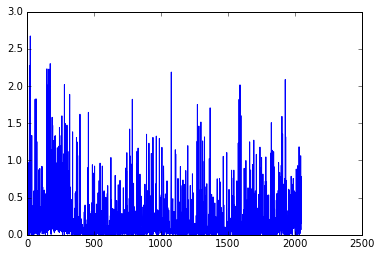

In [11]:
#plt.plot(range(0,features.shape[1]), features)
print features
plt.plot(range(0,features.shape[1]),features[0])
plt.show()

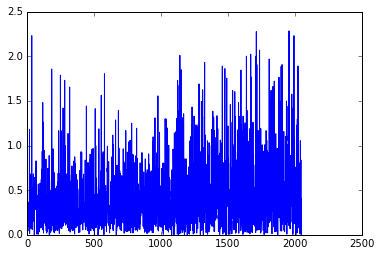

In [12]:
plt.plot(range(0,features.shape[1]),features[1])
plt.show()

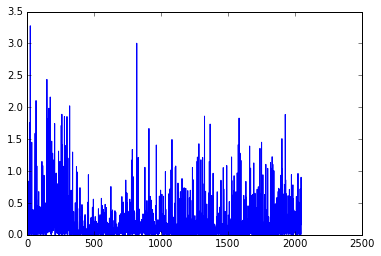

In [13]:
plt.plot(range(0,features.shape[1]),features[2])
plt.show()

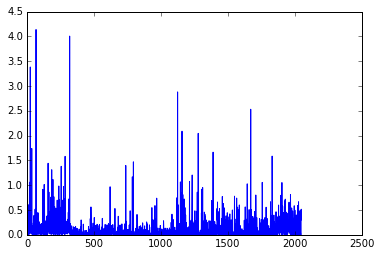

In [14]:
plt.plot(range(0,features.shape[1]),features[3])
plt.show()